In [1]:
# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

### Simple CNN for MNIST 

In [4]:
# Parameters of CNN
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32  # number of feature maps
conv1_ksize = 3   # kernel size 3x3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64      # number of neurons (= outputs) of the fully connected layer
n_outputs = 10  # number of final outputs

# Defining the graph
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Getting the MNIST data and defining training/validation/test sets

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Running the graph

In [6]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [7]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9775
1 Last batch accuracy: 0.98 Test accuracy: 0.9841
2 Last batch accuracy: 0.98 Test accuracy: 0.979
3 Last batch accuracy: 0.99 Test accuracy: 0.9886
4 Last batch accuracy: 0.99 Test accuracy: 0.9883
5 Last batch accuracy: 1.0 Test accuracy: 0.9892
6 Last batch accuracy: 0.99 Test accuracy: 0.9891
7 Last batch accuracy: 1.0 Test accuracy: 0.9899
8 Last batch accuracy: 1.0 Test accuracy: 0.9871
9 Last batch accuracy: 1.0 Test accuracy: 0.989


### A variation with dropout and early stopping

In [10]:
# Parameters of CNN
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32  # number of feature maps
conv1_ksize = 3   # kernel size 3x3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 64      # number of neurons (= outputs) of the fully connected layer
fc1_dropout_rate = 0.5
n_outputs = 10  # number of final outputs

# Defining the graph
reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.layers.dropout(pool3_flat, conv2_dropout_rate, training=training)

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat_drop, n_fc1, activation=tf.nn.relu, name="fc1")
    fc1_drop = tf.layers.dropout(fc1, fc1_dropout_rate, training=training)

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1_drop, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Functions to speed up early stopping operations

In [11]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Running

In [12]:
n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model_02")

Epoch 0, last batch accuracy: 98.0000%, valid. accuracy: 97.7600%, valid. best loss: 0.076830
Epoch 1, last batch accuracy: 98.0000%, valid. accuracy: 98.4600%, valid. best loss: 0.055612
Epoch 2, last batch accuracy: 98.0000%, valid. accuracy: 98.1400%, valid. best loss: 0.046308
Epoch 3, last batch accuracy: 98.0000%, valid. accuracy: 98.9000%, valid. best loss: 0.046308
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy: 98.6600%, valid. best loss: 0.041948
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy: 98.9800%, valid. best loss: 0.041948
Epoch 6, last batch accuracy: 100.0000%, valid. accuracy: 98.9800%, valid. best loss: 0.040954
Epoch 7, last batch accuracy: 100.0000%, valid. accuracy: 98.9400%, valid. best loss: 0.040954
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy: 99.0400%, valid. best loss: 0.039260
Epoch 9, last batch accuracy: 98.0000%, valid. accuracy: 98.9200%, valid. best loss: 0.039260
Epoch 10, last batch accuracy: 100.0000%, valid. accura

# Animal images

### Getting the images

In [13]:
width = 299
height = 299
channels = 3

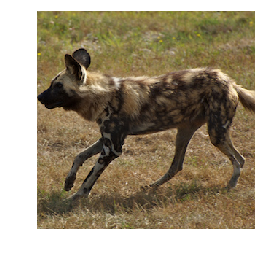

In [15]:
import matplotlib.image as mpimg
test_image = mpimg.imread("test_image.png")[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [16]:
test_image.shape

(299, 299, 3)

In [17]:
test_image[:3,:3,0]

array([[0.49019608, 0.5411765 , 0.57254905],
       [0.45882353, 0.49019608, 0.5294118 ],
       [0.4509804 , 0.46666667, 0.4862745 ]], dtype=float32)

In [18]:
test_image = 2 * test_image - 1

In [19]:
test_image[:3,:3,0]

array([[-0.01960784,  0.082353  ,  0.14509809],
       [-0.08235294, -0.01960784,  0.05882359],
       [-0.09803921, -0.06666666, -0.02745098]], dtype=float32)

In [20]:
import sys
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [21]:
fetch_pretrained_inception_v3()

Downloading: 100%

In [24]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    path = "imagenet_class_names.txt"
    with open(path, encoding="utf-8") as f:
        content = f.read()
        return CLASS_NAME_REGEX.findall(content)

In [25]:
class_names = ["background"] + load_class_names()

In [26]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

### Using the *Inception v3* model for classifying large images

In [27]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [29]:
X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [30]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

276

In [31]:
class_names[most_likely_class_index]

'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus'

In [34]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 93.13%
hyena, hyaena: 2.57%
European fire salamander, Salamandra salamandra: 0.06%
bearskin, busby, shako: 0.05%
swimming trunks, bathing trunks: 0.05%
